# Data Science Final Project


For my final project, I chose to utilize Natural Language Processing (NLP) for sentiment analysis.

In [28]:
# install packages (for use on a differect computer)
# !pip install --user --upgrade nltk
# !pip install --user --upgrade keras
# !pip install --user --upgrade tensorflow
# !pip install --user --upgrade textblob
# !pip install --user --upgrade tqdm
# !pip install --user --upgrade time

# for progress bars
from tqdm import tqdm
import time

from matplotlib import pyplot
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from datetime import datetime
import time
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import gc
from dateutil import parser
import string
import keras
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sklearn.linear_model import SGDClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SpatialDropout1D
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 1000
tqdm.pandas()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tdepa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Here are some of the references that I used (for downloading the data and with code help)

https://www.kaggle.com/datasets/kazanova/sentiment140

https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/

https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format

https://www.kaggle.com/datasets/gpreda/covid19-tweets

## Importing Dataset

Here, I import the dataset containing the pre-analyzed tweets. I fix the dataframe a little to work better with the machine learning model. I also shuffle the dataset, as it is originally sorted with all positives first and then negative tweets.

In [3]:
df = pd.read_csv('twitterdata.csv', encoding = "ISO-8859-1")
print('Loaded file.')
df = pd.DataFrame(np.vstack([df.columns, df])) # Moves column names into row 1
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'tweet'] # Renames columns
df.replace({'sentiment': {4: 1}}, inplace=True) # Replaces all '4's with '1's in column 'sentiment'
df.replace({'sentiment': {0: -1}}, inplace=True) # Replaces all '0's with '-1's in column 'sentiment'
data_types_dict = {
    'sentiment': int,
    'id': float
}
df = df.astype(data_types_dict) # changes value types
df.dtypes

Loaded file.
Fixed sentiment values.


sentiment      int32
id           float64
date          object
query         object
user          object
tweet         object
dtype: object

In [4]:
df = df.sample(frac=1).reset_index(drop=True) # shuffles rows so its not all 1 and then -1
df = df[['sentiment', 'tweet']]
df.head()

,sentiment,tweet
0,-1,"@ddalisay621, yep we have the same Anni. It's creepy I miss ya! We needa chill..very soon! Haha. Im going shopping with my cousin on wed!"
1,1,"@jerrodr Lazy days are good..especially with what's headed our way this week. Glad you had a good weekend. Mine was good, too!"
2,-1,Just got home from work and it's my turn to do dishes.
3,1,hey guys!
4,-1,Received the #brotherscider festival pack today. Shame I'm not going to glasto so no free hooch for me Least I got a free hat!


In [5]:
s = df.stack().value_counts()
print(s)

1                                                                                                                                               800000
-1                                                                                                                                              799999
isPlayer Has Died! Sorry                                                                                                                           210
good morning                                                                                                                                       118
headache                                                                                                                                           115
                                                                                                                                                 ...  
@aussiecynic I may have to peek eh. Especially if I have some restoration to do eh            

In [6]:
# for i in range(10):
#     print(df['tweet'][i])
content = df['tweet'][:5000].values.tolist()
labels = df['sentiment'][:5000].values.tolist()
content = [x.strip() for x in content] # Deletes white space before and after
content[:20]

["@ddalisay621, yep we have the same Anni. It's creepy  I miss ya! We needa chill..very soon! Haha. Im going shopping with my cousin on wed!",
 "@jerrodr Lazy days are good..especially with what's headed our way this week.  Glad you had a good weekend.  Mine was good, too!",
 "Just got home from work and it's my turn to do dishes.",
 'hey guys!',
 "Received the #brotherscider festival pack today. Shame I'm not going to glasto so no free hooch for me  Least I got a free hat!",
 '@tommcfly reply to our random tweets, then fly over lovely England, a few more tweets and then rest for tomorrows opening night  good ;)',
 "Don't worry - we're from the internets. It's going to be alright.",
 "watching VG Topp 20-lista, I can't be there",
 '@MaggieBrown5 dont you know where you are from?? Mayfield all the way! (unless its my dads homemade milky way!)',
 'so, this pretty much sucks, the guy i like i only get to see at school, and summers almost here. so, i pretty much have to give up, sh!t.',
 "

In [7]:
y = np.array(labels, dtype='int8')
y[:20]

array([-1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  1,
       -1, -1, -1], dtype=int8)

In [8]:
# REWORKED WITH REVIEWS DATASET
# df = dfreviews
# content = df['text'].values.tolist()
# labels = df['label'].values.tolist()
# content = [x.strip() for x in content] # Deletes white space before and after
# print(content[:20])
# y = np.array(labels, dtype='int8')
# print(y[:20])

## stop words #1

In [9]:
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
remove_digits = [full_remove(x, digits) for x in content]

## Remove punctuation
remove_punc = [full_remove(x, list(string.punctuation)) for x in remove_digits]

## Make everything lower-case and remove any white space
sents_lower = [x.lower() for x in remove_punc]
sents_lower = [x.strip() for x in sents_lower]

## Remove stop words
from nltk.corpus import stopwords
stops = stopwords.words("English")
def removeStopWords(stopWords, txt):
    newtxt = ' '.join([word for word in txt.split() if word not in stopWords])
    return newtxt
content1 = [removeStopWords(stops,x) for x in sents_lower]
content1[:20]

['ddalisay yep anni creepy miss ya needa chill soon haha im going shopping cousin wed',
 'jerrodr lazy days good especially headed way week glad good weekend mine good',
 'got home work turn dishes',
 'hey guys',
 'received brotherscider festival pack today shame going glasto free hooch least got free hat',
 'tommcfly reply random tweets fly lovely england tweets rest tomorrows opening night good',
 'worry internets going alright',
 'watching vg topp lista',
 'maggiebrown dont know mayfield way unless dads homemade milky way',
 'pretty much sucks guy like get see school summers almost pretty much give sh',
 'believe vaca working tomorrow',
 'cinnamon hey haahaha school tomorrow thank god friday missed miss wetherall cat today oh im sad missed haha',
 'kate kennedy unfortunately reroute trip get home earlier see tai carolina liar amp empires days row',
 'making dinner getting ready candis cayne show abbey boys',
 'andrea k download away pooter tune',
 'ashleyltmsyf wait get married im c

## stops we defined instead

In [10]:
stop_set = ['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']
content2 = [removeStopWords(stop_set,x) for x in sents_lower]
content2[:20]

['ddalisay yep we have same anni s creepy miss ya we needa chill very soon haha im going shopping with my cousin on wed',
 'jerrodr lazy days are good especially with what s headed our way this week glad you had good weekend mine was good too',
 'just got home work and s my turn do dishes',
 'hey guys',
 'received brotherscider festival pack today shame m not going glasto so no free hooch for me least got free hat',
 'tommcfly reply our random tweets then fly over lovely england few more tweets and then rest for tomorrows opening night good',
 'don t worry we re internets s going be alright',
 'watching vg topp lista can t be there',
 'maggiebrown dont you know where you are mayfield all way unless its my dads homemade milky way',
 'so this pretty much sucks guy like only get see at school and summers almost here so pretty much have give up sh t',
 'can t believe vaca is over working tomorrow',
 'cinnamon hey haahaha school tomorrow thank god its friday missed miss wetherall do cat tod

## stemming

In [11]:
# import nltk
# def stemporter(words):
#     porter = nltk.PorterStemmer()
#     new_words = [porter.stem(w) for w in words]
#     return new_words
    
# def stemlancaster(words):
#     porter = nltk.LancasterStemmer()
#     new_words = [porter.stem(w) for w in words]
#     return new_words    

# porter = [stemporter(x.split()) for x in content2]
# porter = [" ".join(i) for i in porter]
# porter[0:10]

## vectorizing

In [12]:
vectorizer = CountVectorizer(analyzer = "word", 
                             preprocessor = None, 
                             stop_words =  'english', 
                             max_features = 6000, ngram_range=(1,5))
data_features = vectorizer.fit_transform(content2)
tfidf_transformer = TfidfTransformer()
data_features_tfidf = tfidf_transformer.fit_transform(data_features)
data_mat = data_features_tfidf.toarray()

np.random.seed(0)
test_index = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_index = list(set(range(len(labels))) - set(test_index))
train_data = data_mat[train_index,]
train_labels = y[train_index]
test_data = data_mat[test_index,]
test_labels = y[test_index]

#Create polarity function and subjectivity function
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
pol_list = [pol(x) for x in content2]
sub_list = [sub(x) for x in content2]

In [13]:
for i in range(10):
    print(content2[i], '\t', pol_list[i], sub_list[i])

ddalisay yep we have same anni s creepy miss ya we needa chill very soon haha im going shopping with my cousin on wed 	 -0.024999999999999994 0.43125
jerrodr lazy days are good especially with what s headed our way this week glad you had good weekend mine was good too 	 0.3916666666666666 0.8000000000000002
just got home work and s my turn do dishes 	 0.0 0.0
hey guys 	 0.0 0.0
received brotherscider festival pack today shame m not going glasto so no free hooch for me least got free hat 	 -0.033333333333333326 0.6666666666666666
tommcfly reply our random tweets then fly over lovely england few more tweets and then rest for tomorrows opening night good 	 0.3 0.5583333333333333
don t worry we re internets s going be alright 	 0.0 0.0
watching vg topp lista can t be there 	 0.0 0.0
maggiebrown dont you know where you are mayfield all way unless its my dads homemade milky way 	 0.0 0.0
so this pretty much sucks guy like only get see at school and summers almost here so pretty much have giv

In [14]:
## Fit logistic classifier on training data
clf = SGDClassifier(loss="log", penalty="none")
clf.fit(train_data, train_labels)
## Pull out the parameters (w,b) of the logistic regression model
w = clf.coef_[0,:]
b = clf.intercept_
## Get predictions on training and test data
preds_train = clf.predict(train_data)
preds_test = clf.predict(test_data)
## Compute errors
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))
print("Training error: ", float(errs_train)/len(train_labels))
print("Test error: ", float(errs_test)/len(test_labels))

Training error:  0.041777777777777775
Test error:  0.32


In [15]:
## Convert vocabulary into a list:
vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])
## Get indices of sorting w
inds = np.argsort(w)
## Words with large negative values
neg_inds = inds[0:50]
print("Highly negative words: ")
# MB: fixed bug here
print([x for x in list(vocab[neg_inds])])
## Words with large positive values
pos_inds = inds[-49:-1]
print("Highly positive words: ")
print([x for x in list(vocab[pos_inds])])

Highly negative words: 
['sad', 'miss', 'hate', 'sucks', 'headache', 'stupid', 'sadly', 'dunno', 'boo', 'hurt', 'crap', 'disappointed', 'missing', 'exam', 'sorry', 'upset', 'isn', 'agh', 'queues', 'tried', 'record', 'ugh', 'miss dad', 'miserable', 'hrs', 'tv', 'didnt', 'confused', 'broke', 'raining', 'wtf', 'slower', 'late', 'crying', 'hates', 'wasnt', 'club', 'got excited', 'boring', 'lately', 'parties', 'ive', 'calling', 'damn', 'board', 'bad', 'thursday', 'download', 'qwerty', 'started']
Highly positive words: 
['present', 'salads', 'dinner', 'mark', 'surprise', 'happy', 'banksyart', 'hehe', 'just woke', 'good morning', 'agreed', 'spammers', 'awesome', 'smile', 'wait th', 'pity', 'em', 'graduating', 'hanging', 'bright', 'great', 'consider', 'day today', 'love', 'pic', 'hr', 'lovely', 'assignments', 'loves', 'petemc', 'cool', 'cute', 'kaccat', 'ha', 'listening', 'fly', 'tht', 'amazing', 'magic', 'thanx', 'damned', 'mall', 'thank', 'thanks', 'loved', 'yea', 'ff', 'excited']


In [16]:
print(clf.predict(vectorizer.transform(["It's a sad movie but very good"])))
print(clf.predict(vectorizer.transform(["Waste of my time"])))
print(clf.predict(vectorizer.transform(["It is not what like"])))
print(clf.predict(vectorizer.transform(["It is not what I m looking for"])))

[-1]
[1]
[-1]
[1]


In [17]:
from sklearn.linear_model import SGDClassifier
svm_clf = SGDClassifier(loss="hinge", penalty='l2')
svm_clf.fit(train_data, train_labels)
svm_preds_test = svm_clf.predict(test_data)
svm_errs_test = np.sum((svm_preds_test > 0.0) != (test_labels > 0.0))
print("Test error: ", float(svm_errs_test)/len(test_labels))

Test error:  0.346


In [18]:
print(svm_clf.predict(vectorizer.transform(["It's a sad movie but very good"])))
print(svm_clf.predict(vectorizer.transform(["Waste of my time"])))
print(svm_clf.predict(vectorizer.transform(["This is not what I like"])))
print(svm_clf.predict(vectorizer.transform(["It is not what I am looking for"])))

[-1]
[1]
[-1]
[1]


In [19]:
max_review_length = 200
tokenizer = Tokenizer(num_words=10000,  #max no. of unique words to keep
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True #convert to lower case
                     )
tokenizer.fit_on_texts(content2)

X = tokenizer.texts_to_sequences(content2)
X = pad_sequences(X, maxlen= max_review_length)
print('Shape of data tensor:', X.shape)

Y=pd.get_dummies(y).values

np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))
train_data = X[train_inds,]
train_labels = Y[train_inds]
test_data = X[test_inds,]
test_labels = Y[test_inds]

Shape of data tensor: (5000, 200)


In [20]:
EMBEDDING_DIM = 200
model = Sequential()
model.add(Embedding(10000, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(250, dropout=0.2,return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          2000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 200)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 200, 250)          451000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               140400    
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 2,591,602
Trainable params: 2,591,602
Non-trainable params: 0
______________________________________________

In [21]:
epochs = 2
batch_size = 40
model.fit(train_data, train_labels, 
          epochs=epochs, 
          batch_size=batch_size,
          validation_split=0.1)

Epoch 1/2
102/102 [==============================] - 116s 1s/step - loss: 0.6462 - accuracy: 0.6217 - val_loss: 0.5641 - val_accuracy: 0.7244
Epoch 2/2
102/102 [==============================] - 115s 1s/step - loss: 0.4181 - accuracy: 0.8185 - val_loss: 0.5708 - val_accuracy: 0.7200


In [22]:
loss, acc = model.evaluate(test_data, test_labels, verbose=2,
                            batch_size=batch_size)
print(f"Loss: {loss}")
print(f"Validation accuracy: {acc}")

13/13 - 3s - loss: 0.5551 - accuracy: 0.7500 - 3s/epoch - 253ms/step
Loss: 0.5551156401634216
Validation accuracy: 0.75


In [23]:
outcome_labels = ['Negative', 'Positive']
new = ["test"]
 
def predict_sentiment(text, pr):
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(seq, maxlen=max_review_length)
    if pr:
        pred = model.predict(padded)
        print("Probability distribution: ", pred)
        print(f"Is this a Positive or Negative message? '{text[0]}'")
        print(outcome_labels[np.argmax(pred)])
    else:
        pred = model.predict(padded, verbose=0)
    return outcome_labels[np.argmax(pred)]

predict_sentiment(new, True)

1/1 [==============================] - 1s 915ms/step
Probability distribution:  [[0.66658044 0.3334196 ]]
Is this a Positive or Negative message? 'test'
Negative


'Negative'

In [30]:
print(predict_sentiment(['kys'], True))

1/1 [==============================] - 0s 83ms/step
Probability distribution:  [[0.45211548 0.5478846 ]]
Is this a Positive or Negative message? 'kys'
Positive
Positive


In [31]:
dfcovid = pd.read_csv('covid19_tweets.csv')
dfcovid = dfcovid[['text']]
dfcovid['text'] = dfcovid['text'].str.replace(r'https?://\S+', '', case=False)
dfcovid = dfcovid[:5000]
dfcovid

C:\Users\tdepa\AppData\Local\Temp\ipykernel_3256\1420892159.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  dfcovid['text'] = dfcovid['text'].str.replace(r'https?://\S+', '', case=False)


,text
0,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that…"
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A…
2,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to…
3,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me…
4,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @airnewsalerts @ANI…
...,...
4995,U-23 coach David Prats had already taken Xavi’s place at the pre-match press conference and there were rumours flyi…
4996,That's your plan to stop the global protest against corruption that started in 2019 ?\n\nU found friends in China h…
4997,"If you’re waiting for a break from bad news about COVID, don’t hold your breath — or, actually, do hold your breath…"
4998,#classicozo #RihannaXTiwa #alreadyvideo #bbnaijalockdown2020 #LucyOurMama #COVID19 \nThis boy no go kill me 🤣🤣🤣


In [ ]:
dfcovid['result'] = dfcovid.progress_apply(lambda row: predict_sentiment([row.text], False), axis=1)
dfcovid.head()

 49%|████▉     | 2466/5000 [07:06<09:00,  4.68it/s]

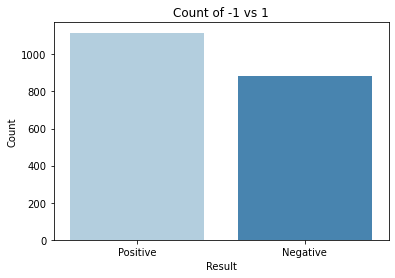

In [27]:
# Use seaborn to create a bar graph
sns.countplot(x='result', data=dfcovid, palette='Blues')

# Add labels and show the plot
plt.xlabel('Result')
plt.ylabel('Count')
plt.title('Count of -1 vs 1')
plt.show()